In [1]:
# Baysian Linear Regression
# Flu Data, filename: `

using DataFrames
using CSV
using GLM
using Plots
#using PyPlot
using Mamba 
using StatsPlots
using DelimitedFiles
using LinearAlgebra
using Query
using Gnuplot
pwd()
Gnuplot.options.verbose=false

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Mamba [5424a776-8be3-5c5b-a13f-3551f69ba0e6]
└ @ Base loading.jl:1260
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260
┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1260


false

In [2]:
## read the data
yearly_dat = (CSV.File("./flu_AB_yearly_data.csv")) |> DataFrame
resp_dat = CSV.File("./yearly_data_resp_diseases.csv") |> DataFrame

#dat = readdlm("./Leinhardt.csv", ',', header=false, skipstart=1) |> DataFrame
#rename!(dat, [:income, :infant, :region, :oil])
#convert(Float64, dat.infant)
#dat[!,:infant] = convert.(Float64,dat[!,:infant])
# dat.infant = passmissing(parse).(Float64, dat.infant)
cols = names(yearly_dat)
println(eltype.(eachcol(yearly_dat)))
println(cols)

# only need the first 26 weeks
yearly_dat = yearly_dat |> @filter(_.Week ∈ 1:26) |> DataFrame 
#yearly_dat = yearly_dat |> @filter(_.Week > 11 && _.Week <=26) |> DataFrame 
resp_dat = resp_dat |> @filter(_.Week ∈ 1:26) |> DataFrame

xvals = yearly_dat.Week
ytitles = cols[2:end]
#@gp "set term qt 0 size 500,500 font 'Sans,9' "  ## pops up in a qt 
@gp "set term svg enhanced standalone mouse size 600,400" ## use jupyter
#@gp "set term png enhanced size 600,400" ## use jupyter
#@gp "set size 0.5,0.5" ## sets the size wrt to the canvas
@gp :- tit="Flu Tests Positivity Rate" key="opaque" linetypes(:Paired_10)
@gp :- "set xtics 1" "set xlabel 'Week'" "set ylabel 'Positivity Rate"
for yt in ytitles 
    @gp :- xvals yearly_dat[!, Symbol(yt)] "w l t '$(yt)' lw 0.6" :- 
end
## add the mean of these  
ymeans =  mean.(eachrow(yearly_dat[!, ytitles]))
yearly_dat[!, :ymeans] .= ymeans # append the data
@gp :- xvals ymeans "with points pt 7 pointsize 0.65 lc rgb 'black'"
@gp :- xvals ymeans "w l t 'mean' lw 3 lc rgb 'black'"

DataType[Int64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64]
["Week", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"]


In [3]:
## apply frequentist linear regression on the mean 
## from a bayesian point of view, this is really using flat, non informative priors

## define a linear model
lmod = lm(@formula(ymeans ~ Week), yearly_dat)
#dat.infant
display(lmod)
println("deviance: $(deviance(lmod))")
println("r2: $(r2(lmod))")

## plot on top of the previous gnuplot -- use :- to continue the plot. 
pvals = predict(lmod)
@gp :- xvals pvals "w l t 'predicted' linetype 4 dashtype 1 lw 3 lc rgb 'red'"

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

ymeans ~ 1 + Week

Coefficients:
────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  20.7954     0.551028    37.7393    <1e-22  19.6581    21.9327
Week         -0.827203   0.0356804  -23.1837    <1e-17  -0.900844  -0.753562
────────────────────────────────────────────────────────────────────────────

deviance: 44.685369829223525
r2: 0.9572561582719025


## Bayesian Formulation
Consider the model from above: $y = \beta_0 + \beta_1x$. The Bayesian linear regression model is as follows: 

\begin{align}
    y &\sim \text{Normal}(\mu, \sigma) \\
    \mu &= \beta^T\mathbf{x} \\
    \beta &\sim \text{Normal(0, 100)} \leftarrow \text{ uninformed, but proper priors } \\
    \sigma^2 &\sim \text{InverseGamma()}
\end{align}

In [4]:
## MCMC, calculating posterior
## The model has a few stochastic nodes, and mu is a deterministic mode based on linear combination of beta and x values
model = Model(
  y = Stochastic(1,
    (μ, σ2) ->  MvNormal(μ, sqrt(σ2)),
    false
  ),

  μ = Logical(1,
    (xmat, β) ->  xmat * β ,
    false
  ),

  # use a common univariate Normal for the beta values.
  # the "1, " the first argument says that beta is an array
  β =  Stochastic(1,
    () -> Normal(0, 10)
  ),
    
  σ2 = Stochastic(
    () -> InverseGamma(2.5, 25)
  )
)
## Set up the samplers. We can use NUST to sample beta and sigma values to derive the posterior. 
scheme2 = [NUTS([Symbol("β"), Symbol("σ2")])]
setsamplers!(model, scheme2)

Object of type "Model"
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
β:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
σ2:
A monitored node of type "ScalarStochastic"
NaN


In [5]:
# Model DAG 
draw(model)

digraph MambaModel {
	"μ" [shape="diamond", style="filled", fillcolor="gray85"];
		"μ" -> "y";
	"xmat" [shape="box", style="filled", fillcolor="gray85"];
		"xmat" -> "μ";
	"β" [shape="ellipse"];
		"β" -> "μ";
	"y" [shape="ellipse", style="filled", fillcolor="gray85"];
	"σ2" [shape="ellipse"];
		"σ2" -> "y";
}


In [6]:
# Initial conditions and model setup, data

## lets organize the data
## line stores the observed data. 
line = Dict{Symbol, Any}(
  :x => yearly_dat.Week,
  :y => yearly_dat.ymeans
)

# turn the :x to a matrix, append a column of 1s. 
# the names have to match as in the model specification
line[:xmat] = [ones(nrow(yearly_dat)) line[:x]]

display(line[:xmat])

# set up initial values 
# we want three chains, so three sets of initial values
inits = [
  Dict{Symbol, Any}(
    :y => line[:y],   # have to use the data for 
    :β  => rand(Normal(1, 1), 2),
    :σ2 => rand(InverseGamma(2.5, 25))
  )
for i in 1:3   
]

sim1 = mcmc(model, line, inits, 10000, burnin=1000, thin=5, chains=3)

26×2 Array{Float64,2}:
 1.0   1.0
 1.0   2.0
 1.0   3.0
 1.0   4.0
 1.0   5.0
 1.0   6.0
 1.0   7.0
 1.0   8.0
 1.0   9.0
 1.0  10.0
 1.0  11.0
 1.0  12.0
 1.0  13.0
 1.0  14.0
 1.0  15.0
 1.0  16.0
 1.0  17.0
 1.0  18.0
 1.0  19.0
 1.0  20.0
 1.0  21.0
 1.0  22.0
 1.0  23.0
 1.0  24.0
 1.0  25.0
 1.0  26.0

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:30:13 of 0:30:15 remaining]
Chain 1:  10% [0:00:25 of 0:00:28 remaining]
Chain 1:  20% [0:00:17 of 0:00:21 remaining]
Chain 1:  30% [0:00:12 of 0:00:18 remaining]
Chain 1:  40% [0:00:10 of 0:00:16 remaining]
Chain 1:  50% [0:00:08 of 0:00:15 remaining]
Chain 1:  60% [0:00:06 of 0:00:14 remaining]
Chain 1:  70% [0:00:04 of 0:00:14 remaining]
Chain 1:  80% [0:00:03 of 0:00:14 remaining]
Chain 1:  90% [0:00:01 of 0:00:13 remaining]
Chain 1: 100% [0:00:00 of 0:00:13 remaining]

Chain 2:   0% [0:00:01 of 0:00:01 remaining]
Chain 2:  10% [0:00:01 of 0:00:01 remaining]
Chain 2:  20% [0:00:01 of 0:00:01 remaining]
Chain 2:  30% [0:00:01 of 0:00:01 remaining]
Chain 2:  40% [0:00:01 of 0:00:01 remaining]
Chain 2:  50% [0:00:01 of 0:00:01 remaining]
Chain 2:  60% [0:00:01 of 0:00:01 remaining]
Chain 2:  70% [0:00:00 of 0:00:01 remaining]
Chain 2:  80% [0:00:00 of 0:00:01 remaining]
Chain 2:  90% [0:00:00 of 0:00:01 remaining]
Cha

Object of type "ModelChains"

Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

[3.9865452321530146 19.93849183009162 -0.7794931788259072; 3.0678464124514666 21.948041989811596 -0.8592050535365295; … ; 4.628134062623408 21.051699677980313 -0.8384475734345701; 3.553504023490621 20.821986883880776 -0.8087627909208732]

[5.005897561020123 -0.8905867252192738 1.984898273144608; 5.005897561020123 -0.8905867252192738 1.984898273144608; … ; 5.005897561020123 -0.8905867252192738 1.984898273144608; 5.005897561020123 -0.8905867252192738 1.984898273144608]

[4.068944597228451 20.48808256370119 -0.8048900243313406; 3.9731635589575154 20.15786169938763 -0.8004615339608075; … ; 2.7891305722829425 20.059902704386538 -0.7706120051567208; 2.7194000983804205 20.8012977171782 -0.8384729418116914]

In [7]:
## Posterior Inference 
## Values of 1.0 of PSRF show good mixing and convergence
gelmandiag(sim1, mpsrf=true, transform=true) |> Mamba.showall

Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

Gelman, Rubin, and Brooks Diagnostic:
               PSRF    97.5% 
          σ2    1.768   3.553
        β[1]   30.892  76.082
        β[2]   62.184 153.231
Multivariate 3636.079     NaN



In [8]:
## Model Information 
describe(sim1)
println("HPD: \n $(hpd(sim1))")

## Cross-Correlations
println("Cross Corr: \n $(cor(sim1))")

## Autocorrelations in the chains
## Correlation in early lags (i.e close to -1 or 1) tells us to look at our effective size
## and maybe thin out the chains.
println("Auto Corr: \n $(autocor(sim1))")

## State Space Change Rate (per Iteration)
println("State Space Change Rate: \n $(changerate(sim1))")

## Deviance Information Criterion
println("Deviance: \n $(dic(sim1))")

Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

Empirical Posterior Estimates:
         Mean         SD       Naive SE     MCSE        ESS   
  σ2  4.005277645  1.0641313 0.014480992 0.09818286 117.467864
β[1] 13.494442981 10.1904473 0.138674423 1.39724214  53.191611
β[2]  0.113909473  1.3236813 0.018013021 0.18172791  53.054671

Quantiles:
         2.5%       25.0%       50.0%      75.0%      97.5%  
  σ2  2.15304011  3.09240058  4.0113803  5.0058976  5.5151069
β[1] -0.89058673 -0.89058673 20.2093893 20.9306021 21.9498442
β[2] -0.90401233 -0.83696905 -0.7919048  1.9848983  1.9848983

HPD: 
       95% Lower   95% Upper
  σ2  1.93194718  5.1024191
β[1] -0.89058673 21.6955700
β[2] -0.88806618  1.9848983


Cross Corr: 
           σ2        β[1]        β[2]   
  σ2  1.00000000 -0.6670892  0.66602974
β[1] -0.66708924  1.0000000 -0.99933260
β[2]  0.66602974 -0.9993326  1.00000000


Auto Corr: 
          Lag 5         Lag 25        Lag 50       Lag 250  

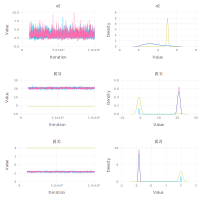

In [9]:
## Plot the trace and posteriors.
p = Mamba.plot(sim1)
draw(p)

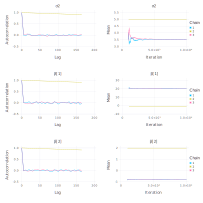

In [10]:
## Autocorrelation and running mean plots
pac = Mamba.plot(sim1, [:autocor, :mean], legend=true)
draw(pac, nrow=3, ncol=2)

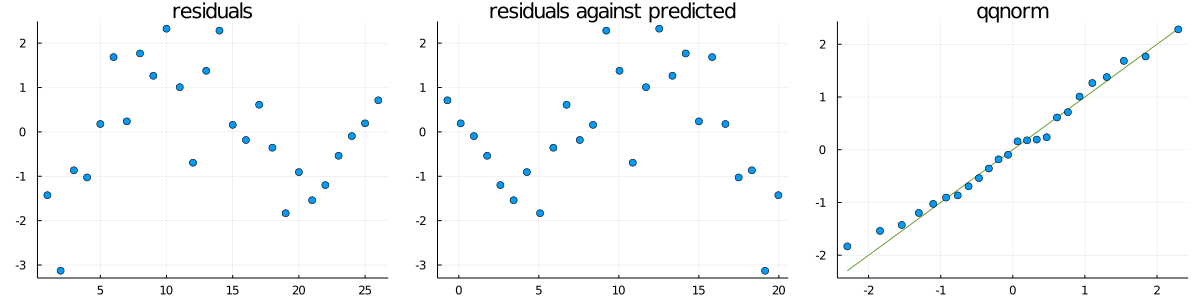

In [11]:
## Lets do some residual checks
## Checking residuals (the difference between the response and the model’s prediction for that value) is important with linear models 
## since residuals can reveal violations of the assumptions we made to specify the model. In particular, we are looking for any 
## sign that the model is not linear, normally distributed, or that the observations are not independent (conditional on covariates).

## lets look at the residuals of the reference linear model 

# plot the residuals to check for indepedence, looks okay actually. 
resid = yearly_dat.ymeans .- predict(lmod)
p1 = Plots.scatter(1:nrow(yearly_dat), resid, title="residuals", legend=false)

# plot the residuals against the predicted values to check for linearity...
p2 = Plots.scatter(predict(lmod), resid, title="residuals against predicted", legend=false) # constant variance (looks bad)

# to check Normality assumption (we want this to be a straight line)
p3 = qqnorm(resid, predict(lmod), title="qqnorm") # note that its not a straight line. looks ike its increasing. .. so our untransformed data dosn't seem normal

Plots.plot(p1, p2, p3, layout=(1, 3), size=(1200, 300))

Bayesian Parameter values for beta: 
 [20.682240449708818, -0.8217668754314146] (ref model: [20.79539660601324, -0.8272029011115218])


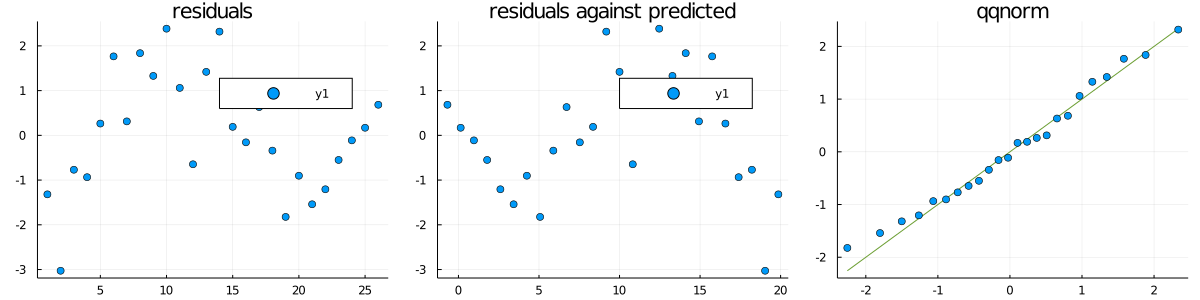

In [12]:
# get the mean of the beta parameters from their posterior
bay_params = mean(sim1.value[:, :, 1], dims=1)[2:3] # using only chain 1 to get the mean value for beta0 and beta1
println("Bayesian Parameter values for beta: \n $(bay_params) (ref model: $(coef(lmod)))")
bay_predicted = line[:xmat] * bay_params
bay_resid = yearly_dat.ymeans - bay_predicted

# plot the residuals
p1 = Plots.scatter(bay_resid, title="residuals")

# plot the residuals against the predicted values to check for linearity...
p2 = Plots.scatter(bay_predicted, bay_resid, title="residuals against predicted")

# and more importantly, check the qq plot to check for normality
p3 = qqnorm(bay_resid, bay_predicted, title="qqnorm") # a fairly straight line now.

Plots.plot(p1, p2, p3, layout=(1, 3), size=(1200, 300))



In [13]:
betavalues = mean(sim1.value[:, :, 1], dims=1)[2:3] # using only chain 1 to get the mean value for beta0 and beta1
sigma = mean(sim1.value[:, :, 1], dims=1)[1]

res = zeros(Float64, 26, 100)
for i = 1:26 
    ydist = Normal(betavalues[1] + betavalues[2]*i, sqrt(sigma))
    res[i, :] .= rand(ydist, 100)
end
meanvals = dropdims(mean(res, dims=2), dims=2)
qlo = zeros(Float64, 26)
qhi = zeros(Float64, 26)
for i = 1:26 
   ql, qh = quantile(res[i, :], [0.025, 0.975])
   qlo[i] = ql 
   qhi[i] = qh
end
dat2020 = resp_dat[!, Symbol("Flu AB")]


26-element Array{Float64,1}:
 17.74193548
  9.6
  9.6069869
 11.53846154
  6.164383562
 10.42471042
  5.769230769
  8.823529412
  3.20855615
  5.825242718
  5.10805501
  0.0
  0.114810563
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [16]:
@gp "set term svg enhanced standalone mouse size 600,400" ## use jupyter
@gp :- tit="Bayesian test" key="opaque" linetypes(:Paired_10)
@gp :- "set xtics 1" "set xlabel 'Week'" "set ylabel 'Positivity Rate"

@gp :- xvals meanvals "with points notitle pt 7 pointsize 0.65 lc rgb 'black'"
@gp :- xvals meanvals "w l t 'mean' lw 3 lc rgb 'black'"
@gp :- xvals qlo "w l t 'qlo' lw 1 lc rgb 'blue'"
@gp :- xvals qhi "w l t 'qhi' lw 1 lc rgb 'blue'"
@gp :- xvals dat2020 "w l t '2020' lw 1.2 lc rgb 'green'"
@gp :- "set yrange [0:25]"


In [18]:
## save the data in dataframe and plot 
save(output="output.svg")
dd = DataFrame(black=meanvals, low=qlo, hi=qhi, data=dat2020)
CSV.write("data_for_seyed.csv", dd)


"data_for_seyed.csv"

In [15]:
diff_in_means = ymeans - meanvals

@gp "set term svg enhanced standalone mouse size 600,400" ## use jupyter
@gp :- "set xtics 1" "set xlabel 'Week'" "set ylabel 'Difference"

@gp :- xvals diff_in_means "with points pt 7 pointsize 0.65 lc rgb 'black'"
@gp :- xvals diff_in_means "w l t 'mean' lw 3 lc rgb 'black'"